# 2. Topic Modeling - Latent Dirchlet Allocation (LDA) + time dimension

In [1]:
# format code
# pip install nb_black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import re
import scipy.sparse
import gensim
import matplotlib.pyplot as plt
from lib.nlp_yt import sw
from gensim.corpora import Dictionary
from gensim import matutils
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer

<IPython.core.display.Javascript object>

### comment condition:  >15words AND 10 unique words

In [3]:
sw = sw.get_stop_words()

<IPython.core.display.Javascript object>

In [4]:
corpora_names = [
    "2019-05",
    "2019-06",
    "2019-07",
    "2019-08",
    "2019-09",
    "2019-10",
    "2019-11",
    "2019-12",
    "2020-01",
    "2020-02",
    "2020-03",
    "2020-04",
    "2020-05",
    "2020-06",
    "2020-07",
    "2020-08",
    "2020-09",
    "2020-10",
    "2020-11",
    "2020-12",
    "2021-01",
    "2021-02",
    "2021-03",
    "2021-04",
    "2021-05",
    "2021-06",
    "2021-07",
    "2021-08",
]

<IPython.core.display.Javascript object>

In [5]:
corpus = pd.read_pickle("data/pickle/corpus_tm_clean_df.pkl")
corpus

,comment,month
0,feier sowas endlich jemand alten cdu stimme ni...,2019-05
1,achtung faschisten irma lo beleidigt user ganz...,2021-06
2,zeigt jahre jahre,2019-05
3,doppelmoralist rezo eigenes video dezember pri...,2021-05
4,richtig,2019-05
...,...,...
229492,legalisierung mehr fahrverbote läuft,2019-05
229493,j pepe leg fakten falsche informationen rausha...,2019-05
229494,bundestag stehen abgeordnete mandat halten unt...,2019-05
229495,liebe user lasst daran hindern frei meinung ek...,2021-07


<IPython.core.display.Javascript object>

In [6]:
corpus_d = {}
for month in corpora_names:
    corpus_d[month] = {
        "len": len(corpus.loc[corpus["month"] == month]),
        "corpora": pd.DataFrame(
            pd.DataFrame(corpus.loc[corpus["month"] == month])["comment"]
        ),
    }


corpora_info = []

for key, value in corpus_d.items():
    corpora_info.append((key, value["len"]))

corpora_docs = [x[1] for x in corpora_info]
corpora_docs_sum = sum(corpora_docs)

print(corpora_info)

[('2019-05', 131834), ('2019-06', 14808), ('2019-07', 2640), ('2019-08', 2395), ('2019-09', 1866), ('2019-10', 1171), ('2019-11', 1287), ('2019-12', 1366), ('2020-01', 1075), ('2020-02', 1131), ('2020-03', 1050), ('2020-04', 1568), ('2020-05', 1379), ('2020-06', 1863), ('2020-07', 1713), ('2020-08', 2104), ('2020-09', 1845), ('2020-10', 1974), ('2020-11', 2150), ('2020-12', 1520), ('2021-01', 3090), ('2021-02', 8085), ('2021-03', 9033), ('2021-04', 11308), ('2021-05', 6824), ('2021-06', 3288), ('2021-07', 9406), ('2021-08', 1724)]


<IPython.core.display.Javascript object>

In [7]:
MIN_WORDS = 15
MIN_UNIQUE_WORDS = 10
progress = 0
print("")

for key, value in corpus_d.items():
    value["texts"] = []
    doc_to_drop = []

    for i in list(value["corpora"].index):
        progress += 1
        if len(value["corpora"].loc[i].comment.split()) < MIN_WORDS:
            doc_to_drop.append(i)
        elif len(set(value["corpora"].loc[i].comment.split())) < MIN_UNIQUE_WORDS:
            doc_to_drop.append(i)
        else:
            # (list of list of str) Tokenized texts, needed for coherence models
            value["texts"].append(value["corpora"].loc[i].comment.split())

        if progress % 100 == 0:
            print(f"progress: {progress}/{corpora_docs_sum}", end="\r")

    value["corpora"] = value["corpora"].drop(index=doc_to_drop)

    d_ = {}
    for i, v in enumerate(list(value["corpora"].index)):
        d_[v] = i
    value["corpora"] = value["corpora"].rename(index=d_)

print("")


progress: 229400/229497


<IPython.core.display.Javascript object>

In [8]:
corpora_filtered_info = [
    (key, len(value["corpora"].index)) for key, value in corpus_d.items()
]
print(corpora_filtered_info)

[('2019-05', 44293), ('2019-06', 6020), ('2019-07', 1064), ('2019-08', 945), ('2019-09', 642), ('2019-10', 409), ('2019-11', 510), ('2019-12', 452), ('2020-01', 340), ('2020-02', 360), ('2020-03', 258), ('2020-04', 410), ('2020-05', 386), ('2020-06', 509), ('2020-07', 419), ('2020-08', 536), ('2020-09', 325), ('2020-10', 371), ('2020-11', 384), ('2020-12', 269), ('2021-01', 678), ('2021-02', 2212), ('2021-03', 3860), ('2021-04', 6106), ('2021-05', 3651), ('2021-06', 1128), ('2021-07', 4501), ('2021-08', 854)]


<IPython.core.display.Javascript object>

In [9]:
docs_post_filtering = [x[1] for x in corpora_filtered_info]
print(f" docs per month (post filtering):\n {docs_post_filtering}")
print(f"\n nr docs (post filtering): {sum(docs_post_filtering)}")

 docs per month (post filtering):
 [44293, 6020, 1064, 945, 642, 409, 510, 452, 340, 360, 258, 410, 386, 509, 419, 536, 325, 371, 384, 269, 678, 2212, 3860, 6106, 3651, 1128, 4501, 854]

 nr docs (post filtering): 81892


<IPython.core.display.Javascript object>

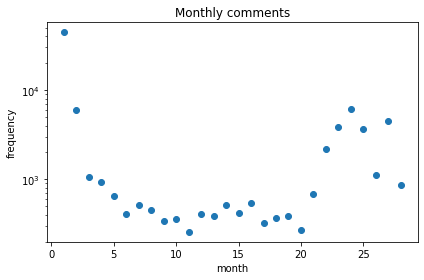

<IPython.core.display.Javascript object>

In [10]:
# scatterplot months
plt.scatter(range(1, len(docs_post_filtering) + 1), docs_post_filtering)
plt.title("Monthly comments")
plt.xlabel("month")
plt.ylabel("frequency")
plt.yscale("log")

plt.savefig("data/pdf/scatter_comments_post_filtering_tm_log.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [11]:
corpora_filtered_percentage = [
    (x[0][0], (round(1 - (x[0][1] / x[1][1]), 2)))
    for x in list(zip(corpora_filtered_info, corpora_info))
]
corpora_filtered_percentage

[('2019-05', 0.66),
 ('2019-06', 0.59),
 ('2019-07', 0.6),
 ('2019-08', 0.61),
 ('2019-09', 0.66),
 ('2019-10', 0.65),
 ('2019-11', 0.6),
 ('2019-12', 0.67),
 ('2020-01', 0.68),
 ('2020-02', 0.68),
 ('2020-03', 0.75),
 ('2020-04', 0.74),
 ('2020-05', 0.72),
 ('2020-06', 0.73),
 ('2020-07', 0.76),
 ('2020-08', 0.75),
 ('2020-09', 0.82),
 ('2020-10', 0.81),
 ('2020-11', 0.82),
 ('2020-12', 0.82),
 ('2021-01', 0.78),
 ('2021-02', 0.73),
 ('2021-03', 0.57),
 ('2021-04', 0.46),
 ('2021-05', 0.46),
 ('2021-06', 0.66),
 ('2021-07', 0.52),
 ('2021-08', 0.5)]

<IPython.core.display.Javascript object>

In [12]:
corpora_filtered_documents_f = [x[1] for x in corpora_filtered_info]
doc_remain_post_tm_cond_perc = [
    x[1] / x[0] for x in zip([x[1] for x in corpora_info], corpora_filtered_documents_f)
]

<IPython.core.display.Javascript object>

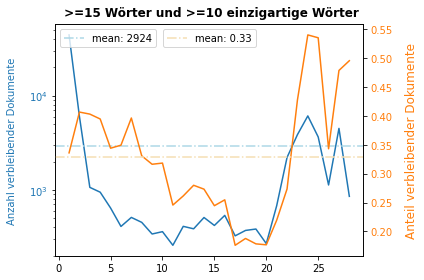

<IPython.core.display.Javascript object>

In [13]:
data_1 = doc_remain_post_tm_cond_perc  # comments remain %
d1_mean = np.mean(data_1)
data_2 = docs_post_filtering  # comments remain #
d2_mean = np.mean(data_2)
data_x = range(1, len(corpora_filtered_percentage) + 1)

fig, ax1 = plt.subplots()
plt.rc("axes", labelsize=12)

color = "tab:blue"
ax1.set_ylabel(
    "Anzahl verbleibender Dokumente", color=color, labelpad=12
)  # we already handled the x-label with ax1
ax1.plot(data_x, data_2, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:orange"
ax2.set_xlabel("Monat")
ax2.set_ylabel("Anteil verbleibender Dokumente", color=color, labelpad=12)
ax2.plot(data_x, data_1, color=color)
ax2.tick_params(axis="y", labelcolor=color)

ax2.set_title(
    " >=15 Wörter und >=10 einzigartige Wörter", fontsize=12, weight="bold", pad=8
)

ax1.axhline(y=d2_mean, color="lightblue", linestyle="-.", label=f"mean: {int(d2_mean)}")
ax2.axhline(y=d1_mean, color="wheat", linestyle="-.", label=f"mean: {round(d1_mean,2)}")

ax2.legend(loc="upper center")
ax1.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("data/pdf/remaining_docs_tmcondition.pdf", bbox_inches="tight")
plt.show()

In [14]:
corpora_filtered_documents_f = [x[1] for x in corpora_filtered_info]
corpora_filtered_documents_sum = sum(corpora_filtered_documents_f)
corpora_filtered_documents_min = min(corpora_filtered_documents_f)
corpora_filtered_documents_max = max(corpora_filtered_documents_f)
corpora_filtered_documents_mean = np.mean(corpora_filtered_documents_f)
corpora_filtered_documents_median = np.median(corpora_filtered_documents_f)
print(f"sum docs: {corpora_filtered_documents_sum}")
print("")
print(f"min docs: {corpora_filtered_documents_min}")
print(f"max docs: {corpora_filtered_documents_max}")
print("")
print(f"mean docs: {corpora_filtered_documents_mean}")
print(f"median docs: {corpora_filtered_documents_median}")

sum docs: 81892

min docs: 258
max docs: 44293

mean docs: 2924.714285714286
median docs: 523.0


<IPython.core.display.Javascript object>

In [15]:
for key, value in corpus_d.items():
    value["tfidf_vectorizer"] = TfidfVectorizer(stop_words=sw)
    value["tfidf_wm"] = value["tfidf_vectorizer"].fit_transform(
        value["corpora"].comment
    )
    value["tfidf"] = pd.DataFrame(
        value["tfidf_wm"].toarray(),
        columns=value["tfidf_vectorizer"].get_feature_names(),
    )
    value["tfidf"].index = value["corpora"].index
    value["tfidf"] = value["tfidf"].transpose()

<IPython.core.display.Javascript object>

In [17]:
for key, value in corpus_d.items():
    value["dictionary"] = Dictionary(value["texts"])
    value["sparse_counts"] = scipy.sparse.csr_matrix(value["tfidf"])
    value["corpus_sparse"] = matutils.Sparse2Corpus(value["sparse_counts"])
    value["id2word"] = dict(
        (v, k) for k, v in value["tfidf_vectorizer"].vocabulary_.items()
    )

<IPython.core.display.Javascript object>

###  evaluate number of topics for each month

In [18]:
start = 3
limit = 8
step = 1
print("")

for key, value in corpus_d.items():
    value["lda_models"] = []
    print(f"processing: {key}", end="\r")

    for num_topics in range(start, limit, step):
        # list of tuple of model,coherence
        lda_model = models.LdaModel(
            corpus=value["corpus_sparse"],
            id2word=value["id2word"],
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            passes=10,
            alpha="auto",
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=value["texts"],
            dictionary=value["dictionary"],
        )
        value["lda_models"].append((lda_model, coherence_model.get_coherence()))

print("")


processing: 2021-08


<IPython.core.display.Javascript object>

In [19]:
for key, value in corpus_d.items():
    print(f"## {key}")
    lda_coherence_values = [x[1] for x in value["lda_models"]]
    num_topics_lda = list(range(start, limit, step))

    assert len(num_topics_lda) == len(lda_coherence_values)

    print(list(zip([str(x) + " Topics" for x in num_topics_lda], lda_coherence_values)))
    print("\n\n")

## 2019-05
[('3 Topics', 0.8005875913529067), ('4 Topics', 0.7887097003467255), ('5 Topics', 0.766768569841263), ('6 Topics', 0.7579447371734465), ('7 Topics', 0.778681489445793)]



## 2019-06
[('3 Topics', 0.7922839569636754), ('4 Topics', 0.7688869634338928), ('5 Topics', 0.7674891497729235), ('6 Topics', 0.7819885303288928), ('7 Topics', 0.7607976028834872)]



## 2019-07
[('3 Topics', 0.8286219671979995), ('4 Topics', 0.8108566309446488), ('5 Topics', 0.8250522640078752), ('6 Topics', 0.7901545850330575), ('7 Topics', 0.799485158668154)]



## 2019-08
[('3 Topics', 0.8103392290245587), ('4 Topics', 0.8053123076535191), ('5 Topics', 0.7932664171883504), ('6 Topics', 0.8014150017698906), ('7 Topics', 0.7909415551032485)]



## 2019-09
[('3 Topics', 0.7580041026050832), ('4 Topics', 0.7639548191374125), ('5 Topics', 0.7784683347214779), ('6 Topics', 0.7577477210000252), ('7 Topics', 0.7659963498889726)]



## 2019-10
[('3 Topics', 0.7883811793456434), ('4 Topics', 0.7970995136702819)

<IPython.core.display.Javascript object>

In [20]:
# get *best* 28 models
num_topics_max_coherence = []

for key, value in corpus_d.items():
    max_coherence = max([x[1] for x in value["lda_models"]])
    nr_topics = None
    for i, t in enumerate(value["lda_models"]):
        if t[1] == max_coherence:
            nr_topics = start + step * i
    num_topics_max_coherence.append((key, nr_topics, max_coherence))

assert len(num_topics_max_coherence) == 28
print(f"nr topics with max coherence per month: \n")
for t in num_topics_max_coherence:
    print(f"{t[0]}  %2s  {t[2]}" % t[1])

nr topics with max coherence per month: 

2019-05   3  0.8005875913529067
2019-06   3  0.7922839569636754
2019-07   3  0.8286219671979995
2019-08   3  0.8103392290245587
2019-09   5  0.7784683347214779
2019-10   4  0.7970995136702819
2019-11   5  0.798987779115789
2019-12   4  0.8013267667768351
2020-01   6  0.8163854963829703
2020-02   3  0.770034171332744
2020-03   3  0.8181749146984285
2020-04   3  0.8184834219262255
2020-05   3  0.8258408113355723
2020-06   4  0.7776270028508628
2020-07   3  0.7399244962814532
2020-08   3  0.7582687968178696
2020-09   3  0.797492366094489
2020-10   5  0.7732855160967038
2020-11   7  0.7384511363007303
2020-12   3  0.8113149037792454
2021-01   5  0.7841385866422901
2021-02   5  0.80496215012164
2021-03   3  0.7994426536766279
2021-04   6  0.7754726356007682
2021-05   3  0.7720045780923476
2021-06   3  0.8014271069209821
2021-07   3  0.8165169605031751
2021-08   3  0.7630653263570099


<IPython.core.display.Javascript object>

In [21]:
print(f"nr topics mean: {np.mean([x[1] for x in num_topics_max_coherence])}")
print(f"nr topics median: {np.median([x[1] for x in num_topics_max_coherence])}")

nr topics mean: 3.8214285714285716
nr topics median: 3.0


<IPython.core.display.Javascript object>

### evaluate best equal number of topics

In [22]:
print(f"pre coherence mean: {np.mean([x[2] for x in num_topics_max_coherence])}")
print(f"pre coherence median: {np.median([x[2] for x in num_topics_max_coherence])}")

pre coherence mean: 0.7917867203798449
pre coherence median: 0.7982400726051391


<IPython.core.display.Javascript object>

In [23]:
d_lda_model_stats_equal_nr_topics = {}

for nr_topics_for_model in range(start, limit, step):
    topic_idx = int((nr_topics_for_model - start) / step)
    for i, (key, value) in enumerate(corpus_d.items()):
        if nr_topics_for_model not in d_lda_model_stats_equal_nr_topics:
            d_lda_model_stats_equal_nr_topics[nr_topics_for_model] = []
        d_lda_model_stats_equal_nr_topics[nr_topics_for_model].append(
            (
                key,
                nr_topics_for_model,
                value["lda_models"][topic_idx][1],
            )
        )
    assert len(d_lda_model_stats_equal_nr_topics[nr_topics_for_model]) == 28

num_topics_mean_coherence = []

for key, value in d_lda_model_stats_equal_nr_topics.items():
    coherence_values = [x[2] for x in value]
    num_topics_mean_coherence.append((key, np.mean(coherence_values)))

num_topics_mean_coherence.sort(key=lambda t: t[1], reverse=True)
print(num_topics_mean_coherence)

[(3, 0.7860641536073588), (4, 0.7805881715698068), (5, 0.7794266399145297), (6, 0.7740060732094006), (7, 0.7712416648737899)]


<IPython.core.display.Javascript object>

In [24]:
# choose best coherence mean for equal number of topics
optimal_eq_num_topics = d_lda_model_stats_equal_nr_topics[
    num_topics_mean_coherence[0][0]
]

<IPython.core.display.Javascript object>

In [25]:
print(f"post coherence mean: {np.mean([x[2] for x in optimal_eq_num_topics])}")
print(f"post coherence median: {np.median([x[2] for x in optimal_eq_num_topics])}")

post coherence mean: 0.7860641536073588
post coherence median: 0.7903325681546594


<IPython.core.display.Javascript object>

In [26]:
optimal_eq_num_topics

[('2019-05', 3, 0.8005875913529067),
 ('2019-06', 3, 0.7922839569636754),
 ('2019-07', 3, 0.8286219671979995),
 ('2019-08', 3, 0.8103392290245587),
 ('2019-09', 3, 0.7580041026050832),
 ('2019-10', 3, 0.7883811793456434),
 ('2019-11', 3, 0.7856263651498109),
 ('2019-12', 3, 0.7948842873758172),
 ('2020-01', 3, 0.8061047087714669),
 ('2020-02', 3, 0.770034171332744),
 ('2020-03', 3, 0.8181749146984285),
 ('2020-04', 3, 0.8184834219262255),
 ('2020-05', 3, 0.8258408113355723),
 ('2020-06', 3, 0.7719380009722805),
 ('2020-07', 3, 0.7399244962814532),
 ('2020-08', 3, 0.7582687968178696),
 ('2020-09', 3, 0.797492366094489),
 ('2020-10', 3, 0.7419299754194948),
 ('2020-11', 3, 0.7231669184927249),
 ('2020-12', 3, 0.8113149037792454),
 ('2021-01', 3, 0.7773203029491578),
 ('2021-02', 3, 0.7773811438743398),
 ('2021-03', 3, 0.7994426536766279),
 ('2021-04', 3, 0.7612360636949198),
 ('2021-05', 3, 0.7720045780923476),
 ('2021-06', 3, 0.8014271069209821),
 ('2021-07', 3, 0.8165169605031751),
 ('

<IPython.core.display.Javascript object>

### inteprete: top 10 keywords -> topic

In [27]:
nr_words = 10


def get_topics_format(topics):
    topics_words = []
    for topic in topics:
        s = topic[1].split("+")
        s = [tuple(x.split("*")) for x in s]
        weights = [float(x[0]) for x in s]
        words = [x[1].replace('"', "") for x in s]
        topics_words.append(list(zip(words, weights)))
    return topics_words


for idx, (key, value) in enumerate(corpus_d.items()):
    nr_t = optimal_eq_num_topics[idx][1]
    lda_index = int((nr_t - start) / step)
    coherence_value = value["lda_models"][lda_index][1]
    print(f"## {key} | {nr_t} Topics | coherence {coherence_value}\n")

    weights = []

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = sum([x[1] for x in topic_words]) / len(topic_words)
        relative_weight = weights_mean * len(topic_words)
        weights.append(relative_weight)

    # normalize sum of relative weights to 1 (0.9999)
    assert len(weights) == nr_t
    weights_sum = sum(weights)
    weights = [round(x * (1 / weights_sum), 4) for x in weights]
    weights_sum = sum(weights)
    assert abs(1 - weights_sum) <= 0.001

    for i, topic_words in enumerate(
        get_topics_format(
            value["lda_models"][lda_index][0].print_topics(num_words=nr_words)
        )
    ):
        weights_mean = sum([x[1] for x in topic_words]) / len(topic_words)
        print(
            f"### Topic: {i+1} | weights_mean: {round(weights_mean,4)} | relative weight: {weights[i]} | "
        )
        print(topic_words, "\n")

    print("\n\n")

## 2019-05 | 3 Topics | coherence 0.8005875913529067

### Topic: 1 | weights_mean: 0.0034 | relative weight: 0.4146 | 
[('video ', 0.005), ('cdu ', 0.004), ('partei ', 0.004), ('grünen ', 0.003), ('wählen ', 0.003), ('menschen ', 0.003), ('rezo ', 0.003), ('afd ', 0.003), ('parteien ', 0.003), ('deutschland', 0.003)] 

### Topic: 2 | weights_mean: 0.0022 | relative weight: 0.2683 | 
[('impressum ', 0.003), ('ströer ', 0.003), ('grenzen ', 0.002), ('tube ', 0.002), ('tubeone ', 0.002), ('religion ', 0.002), ('faz ', 0.002), ('inhalte ', 0.002), ('ramstein ', 0.002), ('wikipedia', 0.002)] 

### Topic: 3 | weights_mean: 0.0026 | relative weight: 0.3171 | 
[('energien ', 0.004), ('erneuerbare ', 0.003), ('strom ', 0.003), ('atmosphäre ', 0.003), ('wind ', 0.003), ('temperatur ', 0.002), ('energie ', 0.002), ('prozent ', 0.002), ('erneuerbaren ', 0.002), ('ipcc', 0.002)] 




## 2019-06 | 3 Topics | coherence 0.7922839569636754

### Topic: 1 | weights_mean: 0.004 | relative weight: 0.5714 |

### Topic: 1 | weights_mean: 0.0059 | relative weight: 0.1192 | 
[('menschen ', 0.011), ('straftaten ', 0.008), ('junge ', 0.008), ('männliche ', 0.008), ('liegt ', 0.004), ('gründe ', 0.004), ('begehen ', 0.004), ('daran ', 0.004), ('negative ', 0.004), ('erfahrungen', 0.004)] 

### Topic: 2 | weights_mean: 0.0205 | relative weight: 0.4141 | 
[('lügen ', 0.032), ('liebe ', 0.032), ('faschisten ', 0.028), ('unterstellungen ', 0.017), ('lügner ', 0.016), ('hetzer ', 0.016), ('birne ', 0.016), ('schrei ', 0.016), ('stummer ', 0.016), ('verbreitet', 0.016)] 

### Topic: 3 | weights_mean: 0.0231 | relative weight: 0.4667 | 
[('grünen ', 0.042), ('annalena ', 0.04), ('baerbock ', 0.04), ('nwort ', 0.026), ('zitat ', 0.018), ('platz ', 0.013), ('saarland ', 0.013), ('spitzenkandidat ', 0.013), ('antidemokratischen ', 0.013), ('männerfeindlichen', 0.013)] 






<IPython.core.display.Javascript object>